In [1]:
#import packages
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ini_data = pd.ExcelFile('Сектор роста_качественные данные.xlsx')
qualitat = ini_data.parse('Qualitative_data')
macro = ini_data.parse('Macrodata')

qualitat.drop(['№', 'Year', 'Name'], axis=1, inplace=True)
qualitat = qualitat.rename(columns={"Default": "target"}) #target = дефолт (1 или 0)

macro.drop(['№', 'Год', 'Название', 'Регион'], axis=1, inplace=True)
macro = macro.rename(columns={"Признак банкротства": "target"}) #target = дефолт (1 или 0)

In [3]:
macro.head()

,target,Unempl_rat,Inflation,SME_GDP,Subsidy_GDP,MC_percent,lnMC_curUS,MC_curUS,Eq_inv,CredPortf,Delinq,Constr,Trade,Com_serv,NonFin,SME_CredPortf,GDP_PPP,GDP,Inf_FedReg
0,0,1.8,14.2,0.199,0.000223,19.10,5.960719,387.889,89.9,1.103533,5.297385,101.6,90.7,98.9,0.96400,4.9,3.526,85.451,13.70
1,0,1.8,6.2,0.216,0.000130,43.34,6.383414,591.945,99.8,0.967147,5.198483,101.8,99.3,100.7,0.95591,4.4,3.539,85.616,5.90
2,0,1.4,3.8,0.220,0.000082,45.80,6.377415,588.405,104.8,1.044952,5.150271,100.7,110.5,101.4,0.95600,4.2,3.819,87.179,3.18
3,0,1.2,4.3,0.202,0.000056,34.66,6.304677,547.125,105.4,1.120463,4.684149,105.3,106.9,101.4,0.95700,4.2,4.306,89.390,4.70
4,0,1.6,3.4,0.206,0.000066,45.45,6.631712,758.780,102.1,1.046283,5.364177,100.0,101.4,100.5,0.95700,7.8,4.433,90.590,3.00


In [5]:
#изначально 17 макро переменных
macro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 19 columns):
target           885 non-null int64
Unempl_rat       885 non-null float64
Inflation        885 non-null float64
SME_GDP          885 non-null float64
Subsidy_GDP      885 non-null float64
MC_percent       885 non-null float64
lnMC_curUS       885 non-null float64
MC_curUS         885 non-null float64
Eq_inv           885 non-null float64
CredPortf        885 non-null float64
Delinq           885 non-null float64
Constr           885 non-null float64
Trade            885 non-null float64
Com_serv         885 non-null float64
NonFin           885 non-null float64
SME_CredPortf    885 non-null float64
GDP_PPP          885 non-null float64
GDP              885 non-null float64
Inf_FedReg       885 non-null float64
dtypes: float64(18), int64(1)
memory usage: 131.4 KB


In [7]:
macro['target'].value_counts()

0    605
1    280
Name: target, dtype: int64

In [8]:
# import packages
import pandas as pd
import numpy as np
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [15]:
final_iv_macro

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Unempl_rat,1.200000,3.200000,311,60,0.192926,251,0.807074,0.214286,0.414876,-0.660670,0.199454
1,Unempl_rat,3.300000,4.800000,285,102,0.357895,183,0.642105,0.364286,0.302479,0.185926,0.199454
2,Unempl_rat,4.900000,18.600000,289,118,0.408304,171,0.591696,0.421429,0.282645,0.399460,0.199454
3,Inflation,1.200000,3.400000,297,103,0.346801,194,0.653199,0.367857,0.320661,0.137310,0.013831
4,Inflation,3.500000,5.300000,293,93,0.317406,200,0.682594,0.332143,0.330579,0.004721,0.013831
5,Inflation,5.400000,14.800000,295,84,0.284746,211,0.715254,0.300000,0.348760,-0.150602,0.013831
6,SME_GDP,0.199000,0.199000,177,56,0.316384,121,0.683616,0.200000,0.200000,0.000000,0.000000
7,SME_GDP,0.202000,0.202000,177,56,0.316384,121,0.683616,0.200000,0.200000,0.000000,0.000000
8,SME_GDP,0.206000,0.206000,177,56,0.316384,121,0.683616,0.200000,0.200000,0.000000,0.000000
9,SME_GDP,0.216000,0.216000,177,56,0.316384,121,0.683616,0.200000,0.200000,0.000000,0.000000


In [16]:
IV_macro.sort_values('IV')

,VAR_NAME,IV
0,Com_serv,0.000000
15,Trade,0.000000
14,Subsidy_GDP,0.000000
13,SME_GDP,0.000000
12,SME_CredPortf,0.000000
11,NonFin,0.000000
10,MC_percent,0.000000
9,MC_curUS,0.000000
17,lnMC_curUS,0.000000
6,GDP_PPP,0.000000


In [17]:
macro_new = macro[['Inflation', 'Inf_FedReg', 'Unempl_rat']]

In [18]:
macro_new.head()

,Inflation,Inf_FedReg,Unempl_rat
0,14.2,13.70,1.8
1,6.2,5.90,1.8
2,3.8,3.18,1.4
3,4.3,4.70,1.2
4,3.4,3.00,1.6


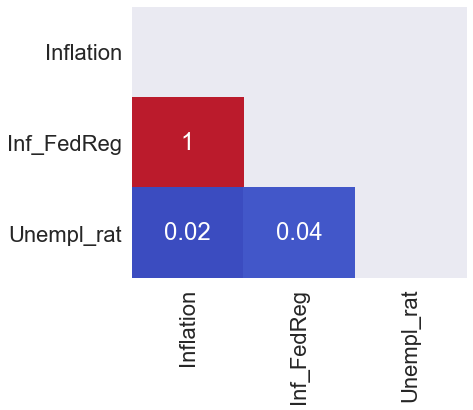

In [19]:
sns.set(font_scale=2)
f, ax = plt.subplots(figsize=(6, 5))
matrix = np.triu(macro_new.corr(method='pearson'))
sns.heatmap(macro_new.corr(method='pearson'), annot=True, mask=matrix, cbar = False, fmt = '.1g', cmap= 'coolwarm')